In [1]:
!pip install pyocclient

In [2]:
!pip install git+https://github.com/paulgavrikov/visualkeras --upgrade

  Cloning https://github.com/paulgavrikov/visualkeras to c:\users\hp\appdata\local\temp\pip-req-build-h1_tc5l4


  Running command git clone -q https://github.com/paulgavrikov/visualkeras 'C:\Users\HP\AppData\Local\Temp\pip-req-build-h1_tc5l4'


In [2]:
# Importing all required modules
import matplotlib.pyplot as plt
import pandas as pd
import os
from io import BytesIO
import owncloud
from datetime import datetime
import numpy as np
from numpy.random import seed
from scipy import signal
import re
import scipy.io
from scipy.fft import fft, fftfreq, rfft, rfftfreq # For FFT
import pickle # For storing variables in local txt files

# Neural Network Based Modules
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
import keras
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv1D,MaxPooling1D, AveragePooling1D
from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import MinMaxScaler # For Data Normalisation
from keras.callbacks import EarlyStopping
import visualkeras
from keras.models import load_model # for saving the trained and validated model and all its parameters

# Importing Local Methods
# from dataFilter import dataFilter # Method for filtering Data
# from mirrorPoint import mirrorPoint # Method for computing the mirror of any given impact location in a quadrant
# from pointQuad import pointQuad # Method for computing the quadrant in which a particular impact location is placed
# from dataSegment import dataSegment # Method for cutting the sensor potential data after the first highest peak
# from expDataSegment import expDataSegment
# from dataNormal import dataNormal
# from dataSegment import dataSegment

<h2>Important Methods</h2>

**Method for computing the mirror of a given Impact Location**

The inputs to the method are the coordinates which we want to mirror, the coordinates of the origin of the shifted coordinate system, and the axis (or origin) about which we want to mirror the location. 

If we mirror about the Y-axis: $$\{ x,y \} \rightarrow \{ 2x_{0} - x, y \}$$
If we mirror about the X-axis: $$\{ x,y \} \rightarrow \{ x, 2y_{0} - y \}$$
If we mirror about the origin: $$\{ x,y \} \rightarrow \{ 2x_{0} - x, 2y_{0} - y \}$$

$x_{0}$ and $y_{0}$ are the coordinates of the origin of the shifted coordinate system.

In [4]:
# Function to mirror any Point about axes and origin of a cartesian coordinate system
# x0,y0: origin coordinates for the egenralised case of a shifted coordinate system

def mirrorPoint(x,y,x0,y0,str):
    
    if str == 'X':
        return x , 2*(y0) - y
    
    elif str == 'Y':
        return 2*(x0) - x, y
    
    elif str == 'Origin':
        return 2*(x0) - x, 2*(y0) - y

**Method for computing the quadrant in which the particular Impact location is placed**

According to the given numerical and experimental data, the following are the $X$ and $Y$ ranges for deciding the quadrants:

***Quadrant 1***:
	\begin{array}{ll}
		 250 \leq x \leq 325 \\
		 250 \leq y \leq 325
	\end{array}
    
***Quadrant 2***:
	\begin{array}{ll}
		 175 \leq x \leq 250 \\
		 250 \leq y \leq 325
	\end{array}

***Quadrant 3***:
	\begin{array}{ll}
		 175 \leq x \leq 250 \\
		 175 \leq y \leq 250
	\end{array}
    
***Quadrant 4***:
	\begin{array}{ll}
		 250 \leq x \leq 325 \\
		 175 \leq y \leq 250
	\end{array}

In [5]:
# Function for deciding the quadrant of a point 
# Based on the Simualtion and Experimental setup of the impact experiment

def pointQuad(x,y,len):
    
    # x: X coordinate of the point
    # y: Y coordinate of the point
    # len: length of the list for storing quadrant of the impact point
    
    quadrant = [] # Empty List for storing the quadrant of impact
    if x >= 250 and x <= 325 and y >= 250 and y <= 325:
        for i in range(0,len):
            quadrant.append('Q1')
            
    elif x >= 175 and x <= 250 and y >= 250 and y <= 325:
        for i in range(0,len):
            quadrant.append('Q2')
            
    elif x >= 175 and x <= 250 and y >= 175 and y <= 250:
        for i in range(0,len):
            quadrant.append('Q3')
            
    elif x >= 250 and x <= 325 and y >= 175 and y <= 250:
        for i in range(0,len):
            quadrant.append('Q4')
            
    return quadrant
            

<h2>Experimental/Simulation Setup</h2>

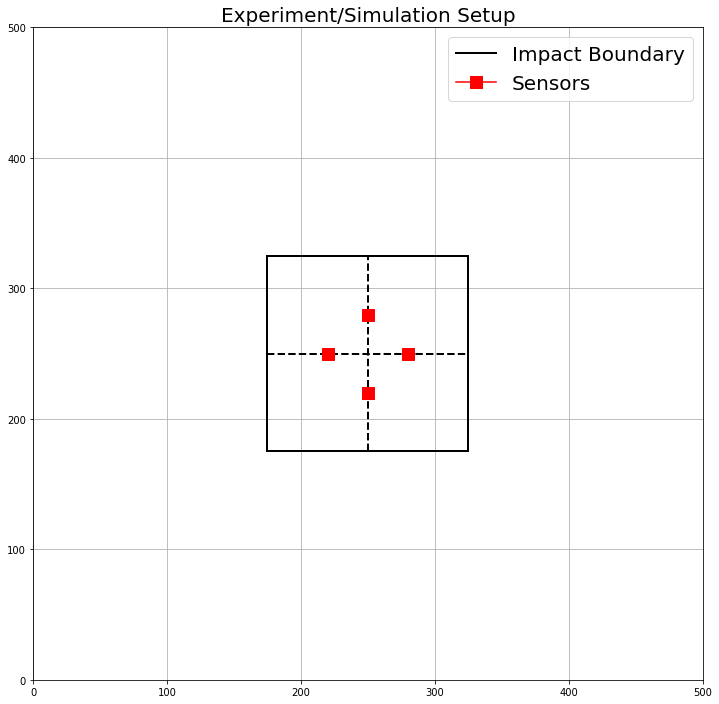

In [6]:
#Sy_ax = range(Oxy_PRED.shape[0])
x1 = 175*np.ones(100)
y1 = np.linspace(175,325,100)
x2 = np.linspace(175,325,100)
y2 = 325*np.ones(100)
x3 = 325*np.ones(100)
y3 = y1
x4 = x2
y4 = 175*np.ones(100)
x5 = 250*np.ones(100)
y5 = np.linspace(175,325,100)
x6 = np.linspace(175,325,100)
y6 = 250*np.ones(100)
plt.figure(figsize = (12,12))
plt.plot(x1,y1,color = 'black',lw = 2,label = 'Impact Boundary')
plt.plot(x2,y2,color = 'black',lw = 2)
plt.plot(x3,y3,color = 'black',lw = 2)
plt.plot(x4,y4,color = 'black',lw = 2)
plt.plot(x5,y5,'--',lw = 2,color = 'black')
plt.plot(x6,y6,'--',lw = 2,color = 'black')
plt.plot(250,280,marker = 's',markersize = 12,color = 'red',label = 'Sensors')
#plt.annotate('S1',(250,280))
plt.plot(280,250,marker = 's',markersize = 12,color = 'red')
#plt.annotate('S2',(280,250))
plt.plot(250,220,marker = 's',markersize = 12,color = 'red')
#plt.annotate('S4',(250,220))
plt.plot(220,250,marker = 's',markersize = 12,color = 'red')
#plt.annotate('S3',(220,250))
plt.axis([0,500,0,500])
plt.legend(prop = {'size' : 20})
plt.title('Experiment/Simulation Setup',fontsize = 20)
plt.grid()
plt.show()


**Method for cutting the sensor potential data after the first highest peak**

The piezoelectric sensor potentials experience an excitation localised around the time the impact of the ball happens. It is very realistic to assume that majority of the significant potential data lies close to the start of the excitation till the highest peak (in terms of absolute value of sensor potential) of the potential for each sensor. Thus, all sensor data, whether experimental or numerical, is cut after the highest peak is obtained. This data segmentation also wouldn't affect the neural network performance since the neural network will be able to still extract the most important features from the data till the highest peak.

In [6]:
# Function for cutting the data after the first highest peak

from scipy import signal
import numpy as np

def dataSegment(Arr,dataNum):
    peakS1, _ = signal.find_peaks(Arr[:,1], height=None)
    peakS2, _ = signal.find_peaks(Arr[:,2], height=None)
    peakS3, _ = signal.find_peaks(Arr[:,3], height=None)
    peakS4, _ = signal.find_peaks(Arr[:,4], height=None)
    

    peakVals1 = np.zeros(peakS1.shape)
    peakVals2 = np.zeros(peakS2.shape)
    peakVals3 = np.zeros(peakS3.shape)
    peakVals4 = np.zeros(peakS4.shape)
    
    k1 = 0
    k2 = 0
    k3 = 0
    k4 = 0
    
    for i in range(0,peakS1.shape[0]):
        peakVals1[i] = Arr[peakS1[i],1]
        
    for i in range(0,peakS1.shape[0]):
        if peakVals1[i] == max(abs(peakVals1)):
            # k1 = i
            k1 = peakS1[i]
            
    for i in range(0,peakS2.shape[0]):
        peakVals2[i] = Arr[peakS2[i],2]
        
    for i in range(0,peakS2.shape[0]):
        if peakVals2[i] == max(abs(peakVals2)):
            # k2 = i
            k2 = peakS2[i]
            
    for i in range(0,peakS3.shape[0]):
        peakVals3[i] = Arr[peakS3[i],3]
        
    for i in range(0,peakS3.shape[0]):
        if peakVals3[i] == max(abs(peakVals3)):
            # k3 = i
            k3 = peakS3[i]
            
    for i in range(0,peakS4.shape[0]):
        peakVals4[i] = Arr[peakS4[i],4]
        
    for i in range(0,peakS4.shape[0]):
        if peakVals4[i] == max(abs(peakVals4)):
            # k4 = i
            k4 = peakS4[i]
    
    
    
    # Each sensor data is cut after its highest peak
    dS1 = Arr[:k1,1]
    dS2 = Arr[:k2,2]
    dS3 = Arr[:k3,3]
    dS4 = Arr[:k4,4]
    
    r = max(k1,k2,k3,k4) # The peak with the maximum index is selected
    
    # The segmented data will have r rows
    # Each sensor data will have data till its highest peak and then be zero
    # till r rows are populated
    
    data_cut = np.zeros(((r,7)))
    data_cut[:,0] = Arr[:r,0]
    data_cut[:k1,1] = dS1
    data_cut[:k2,2] = dS2
    data_cut[:k3,3] = dS3
    data_cut[:k4,4] = dS4
    # Impact Locations
    data_cut[:,5] = Arr[:r,5] 
    data_cut[:,6] = Arr[:r,6]
    
    # Resampling the data
    dataCut = np.zeros((dataNum,7))
    
    dataCut[:,1:5] = signal.resample(data_cut[:,1:5],dataNum) # Resampling sensor Values
    if data_cut.shape[0] > dataNum:
        dataCut[:,5:] = data_cut[:dataNum,5:] # Impact Locations
        
    else:
        dataCut[:,5:] = data_cut[0,5:]*np.ones((dataNum,1))
        
    dataCut[:,0] = np.linspace(data_cut[0,0],data_cut[-1,0],dataNum) # Time Vector
    
    
    
    return dataCut


**Method for Segmentation and Resampling of Experimental Data**

The provided experimental data doesn't actually start recording at the initial time ($t = 0$), instead the first instance of an impact is observed much later. Moreover, after tehe impact is recorded, there seems to be a lot of noisy data till the end of experiment. Thus, the experimental data is seperately segmented, where the region of most relevant data is located and extracted out. We take this region to start 50 datapoints before the highest peak in the experimental data, and then the next 300 datapoints. This extracted region is then again passed through the `dataSegment` function to segment out the most relevant data like the numerical data. 

***Resampling***: Further the extracted region of experimental data is resampled to have the same number of sensor datapoints as the numerical data.

In [7]:
from scipy import signal
import numpy as np

def expDataSegment(Arr):
    peakS1, _ = signal.find_peaks(Arr[:,1], height=None)
    peakS2, _ = signal.find_peaks(Arr[:,2], height=None)
    peakS3, _ = signal.find_peaks(Arr[:,3], height=None)
    peakS4, _ = signal.find_peaks(Arr[:,4], height=None)
    
    S1 = {}
    S2 = {}
    S3 = {}
    S4 = {}
    
    for i in peakS1:
        # Peaks detected at maximum absolute (negative and positive) values
        #S1[i] = np.absolute(Arr[i,1])
        S1[i] = Arr[i,1]
    k1 = max(S1, key=S1.get)
    
    for i in peakS2:
        #S2[i] = np.absolute(Arr[i,2])
        S2[i] = Arr[i,2]
    k2 = max(S2, key=S2.get)
    
    for i in peakS3:
        #S3[i] = np.absolute(Arr[i,3])
        S3[i] = Arr[i,3]
    k3 = max(S3, key=S3.get)
    
    for i in peakS4:
        #S4[i] = np.absolute(Arr[i,4])
        S4[i] = Arr[i,4]
    k4 = max(S4, key=S4.get)
    
    
    fIndex = min(k1,k2,k3,k4) - 50 # 50 datapoints before the first peak
    lIndex = fIndex + 300 # 300 datapoints considered
    
    dataCut = Arr[fIndex:lIndex + 1,:]
    
    return dataCut 

<h2> Parsing Data </h2>

**Types of dataset provided**:
* ***Numerical Simulation Data***: This data will be primarily used as the training and validation data for the neural network. The impact locations corresponding to each sensor data are provided. The provided numerical data only consists of impact locations in the 1st quadrant, and thus needs to be augmented to other quadrants. Due to the symmetric nature of the experimental setup/simulation setup, we can easily augment the numerical data by *mirroring the points across the $X$ and $Y$ axes and the origin.*
* ***Validation Augmentation Data***: This data consists of sensor data corresponding to the point $( 275,265 )$ and its corresponding mirrors in the other three quadrants ($( 225,265 )$, $( 225,235 )$, $( 275,235 )$). This data is used to validate the augmentation of the numerical data.
* ***Experimental validation Data***: This dataset is from the actual experiment and is used partly as training and validation data, and partly as test data for the neural network. It is also used to compare the segmented experimental and numerical data in order to ensure that the experimental data is fit to be put into the model. For the same coordinates, the experimental and numerical sensor data should match very closely.
* ***Group specific Experimental Data***: This experimental sataset doesn't have any impact location coordinates and thus is used as the prediction dataset for the model. The impact locations are introduced in the dataset by the trained, validated and tested Convolutional Neural Network.

In [4]:
#%% Exracting Data
directory = ['/EPOT_Data/','/Validation_augmented_data/','/Experimental_validation/'] # Remote Directories

#%% Accessing the remote directory
numSim_Q1 = [] # Empty List for storing all individual .mat files of the numerical simulations for impact locations in quadrant 1
numSim_Q2 = [] # Empty List for storing all individual .mat files of the numerical simulations for impact locations in quadrant 1
numSim_Q3 = [] # Empty List for storing all individual .mat files of the numerical simulations for impact locations in quadrant 1
numSim_Q4 = [] # Empty List for storing all individual .mat files of the numerical simulations for impact locations in quadrant 1
valAug_data = [] # Empty List for storing all individual .mat files of the validation augmented data
valAug_loc = [] # Empty List for storing the impact coorinates included in the validation augmented data
checkAugData = [] # Empty List for storing the augmented datasets which need to be validated
exp_data = []
numSimData = [] # Empty List for storing all numerical simulation data of all quadrants 
grp14_data = 'https://rwth-aachen.sciebo.de/s/cvQW1nT5Kzgvgms'
public_link = 'https://rwth-aachen.sciebo.de/s/Q114EFBAp1QP3fq'
folder_password = 'CIE_B'
grp14_pw = 'CIE'
oc = owncloud.Client.from_public_link(public_link, folder_password=folder_password)

# oc = owncloud.Client.from_public_link(public_link, folder_password=folder_password)
oc1 = owncloud.Client.from_public_link(grp14_data, folder_password=grp14_pw)

<h3>Parsing Validation Data for Augmentation</h3>

The Augmentation Validation data is given as `.mat` files, which are imported into Python as dictionaries, and then extracted as `numpy` 3D arrays. The same data parsing is carried out for the numerical simulation data.

In [10]:
files = oc.list(directory[1], depth = 'infinity')

for file in files:
    colNames = ['Time', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4']
    mat_df = pd.DataFrame(columns = colNames)
    content = oc.get_file(directory[1] + file.get_name())
    # Loading the .mat file
    mat = scipy.io.loadmat(file.get_name())
    
    # Extracting the Impact Locations from the file names
    x = float(file.get_name().split('_')[1]) # X coordinate of the Impact Location
    y = float(file.get_name().split('_')[2].split('.')[0]) # Y coordinate of the Impact Location
    
    os.remove(file.get_name()) # Removing the file from the local directory once it has been read
    
    mat = mat['num_data']
    
    # Rearranging the numpy arrays into dataframes
    mat_df['Time'] = mat[:,0]
    mat_df['Sensor 1'] = mat[:,1]
    mat_df['Sensor 2'] = mat[:,2]
    mat_df['Sensor 3'] = mat[:,3]
    mat_df['Sensor 4'] = mat[:,4]
    
    # Appending the obtained array to the numSim_data list
    valAug_data.append(mat_df)
    valAug_loc.append((x,y))

<h3> Parsing Numerical Simulation Data</h3>

In [3]:
files_num = oc.list(directory[0], depth = 'infinity') # Obtaining file info and names in the remote folder

for file in files_num:
    colNames = ['Time', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4', 'X', 'Y']
    q1_df = pd.DataFrame(columns = colNames)
    q2_df = pd.DataFrame(columns = colNames)
    q3_df = pd.DataFrame(columns = colNames)
    q4_df = pd.DataFrame(columns = colNames)
    content = oc.get_file(directory[0] + file.get_name()) # Downloading the mat file
    # Loading the .mat file
    mat = scipy.io.loadmat(file.get_name())
    
    # Extracting the Impact Locations from the file names
    x = float(file.get_name().split('_')[1]) # X coordinate of the Impact Location
    y = float(file.get_name().split('_')[2].split('.')[0]) # Y coordinate of the Impact Location
    
    
    os.remove(file.get_name()) # Removing the file from the local directory once it has been read
    
    # We obtain each mat as a dictionary
    # The actual array is stored as the value corresponding to the 4th key ('num_data')
    mat = mat['num_data']
    
    # Evaluating the Quadrant of Impact depending on the Impact Locations
    quadrant = pointQuad(x,y,mat.shape[0])
    
    # Rearranging the numpy arrays into dataframes
    q1_df['Time'] = mat[:,0]
    q1_df['Sensor 1'] = mat[:,1]
    q1_df['Sensor 2'] = mat[:,2]
    q1_df['Sensor 3'] = mat[:,3]
    q1_df['Sensor 4'] = mat[:,4]
    q1_df['X'] = x
    q1_df['Y'] = y
    
     # Appending the obtained array to the numSim_data list
    numSim_Q1.append(q1_df)
    
    
# Format of each .mat file -> 20000 rows and 5 columns
#                          -> First Column: Time Vector
#                          -> Next 4 columns: Electric Potential of 4 Piezoelectric Transducers
    
    # DATA AUGMENTATION
    # The provided simulation data only covers impact locations in 1st Quadrant
    # Each file corresponds to one impact location in the first quadrant
    # For each impact location in Quadrant 1, we can generate the corresponding mirror impact locations in other quadrants
    # For any point P in quadrant 1:
        # Mirror Point in Qudrant 2 -> Mirroring the point across Y axis
        # Mirror Point in Quadrant 3 -> Mirroring the point across origin/Mirroring quad 2 point across X axis
        # Mirror Point in Quadrant 4 -> Mirroring the point across X axis/ Mirroring quad 3 point across Y axis
        
    # The considered coordinate system his shifted and has its origin at (250,250)
        
    # Mirror Point in Quadrant 2
    x,y = mirrorPoint(x,y,250,250,'Y')
    quadrant = pointQuad(x,y,mat.shape[0])
    
    # Rearranging the numpy arrays into dataframes
    # For Quadrant 2 impact location, sensor 4 becomes equivalent to sensor 2 (in quad 1) and vice versa
    q2_df['Time'] = mat[:,0]
    q2_df['Sensor 1'] = mat[:,1]
    q2_df['Sensor 2'] = mat[:,4]
    q2_df['Sensor 3'] = mat[:,3]
    q2_df['Sensor 4'] = mat[:,2]
    q2_df['X'] = x
    q2_df['Y'] = y
    
    numSim_Q2.append(q2_df)
    
    
    # Mirror Point in Quadrant 3
    x,y = mirrorPoint(x,y,250,250,'X')
    quadrant = pointQuad(x,y,mat.shape[0])
    
    # Rearranging the numpy arrays into dataframes
    # For Quadrant 3 impact location, sensor 3 becomes equivalent to sensor 1 (in quad 1) and vice versa
    q3_df['Time'] = mat[:,0]
    q3_df['Sensor 1'] = mat[:,3]
    q3_df['Sensor 2'] = mat[:,4]
    q3_df['Sensor 3'] = mat[:,1]
    q3_df['Sensor 4'] = mat[:,2]
    q3_df['X'] = x
    q3_df['Y'] = y
    
    numSim_Q3.append(q3_df)
    
    # Mirror Point in Quadrant 4
    x,y = mirrorPoint(x,y,250,250,'Y')
    quadrant = pointQuad(x,y,mat.shape[0])
    
    # Rearranging the numpy arrays into dataframes
    # For Quadrant 4 impact location, sensor 4 becomes equivalent to sensor 1 (in quad 1) and vice versa
    q4_df['Time'] = mat[:,0]
    q4_df['Sensor 1'] = mat[:,3]
    q4_df['Sensor 2'] = mat[:,2]
    q4_df['Sensor 3'] = mat[:,1]
    q4_df['Sensor 4'] = mat[:,4]
    q4_df['X'] = x
    q4_df['Y'] = y
    
    # Comparing the augmented data with the validation augmented data provided
    # In the validation data provided, the locations are the corresponding mirrors of (275,265) in quadrant 1
    
    if float(file.get_name().split('_')[1]) == 275 and float(file.get_name().split('_')[2].split('.')[0]) == 265:
        checkAugData.append(q3_df)
        checkAugData.append(q2_df)
        checkAugData.append(q4_df)
        checkAugData.append(q1_df)
        
    
    # For each given impact location in the first quadrant, its corresponding augmented 
    # simulation data in all the other quadrants is also stored
    numSimData.append(q1_df)
    numSimData.append(q2_df)
    numSimData.append(q3_df)
    numSimData.append(q4_df)
    

NameError: name 'oc' is not defined

In [12]:
# Converting the numerical data into a 3D Numpy Array
numSimData = np.array(numSimData)

In [13]:
# Normalisation
# numSimData = dataNormal(numSimData)

# Using MinMaxScaler method
for i in range(0,numSimData.shape[0]):
    numSimData[i,:,1:5] = MinMaxScaler(feature_range = (-1,1)).fit_transform(numSimData[i,:,1:5]) # Normalising between -1 and 1

In [14]:
checkAugData[0].iloc[0,5]

225.0

<h3> Plots for Validating Numerical Data Augmentation </h3>

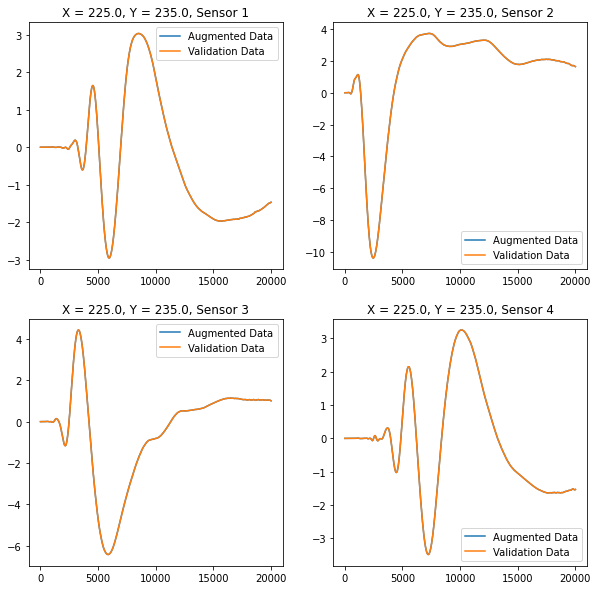

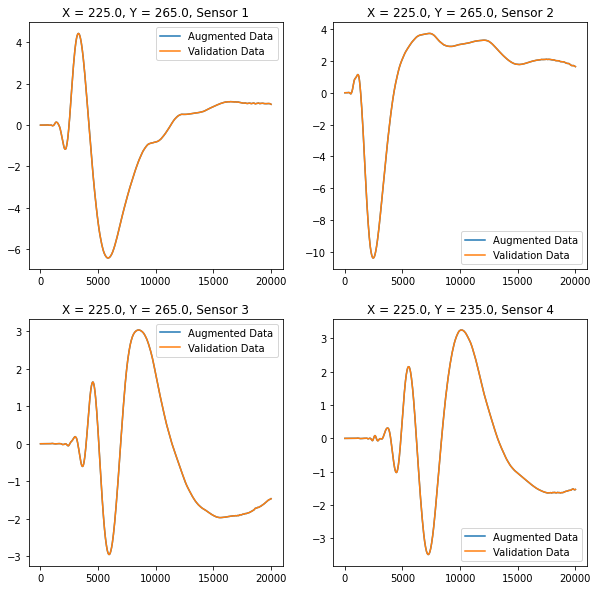

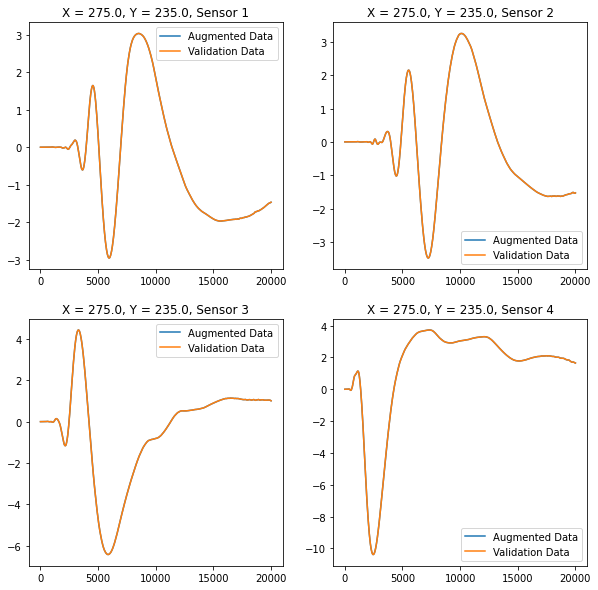

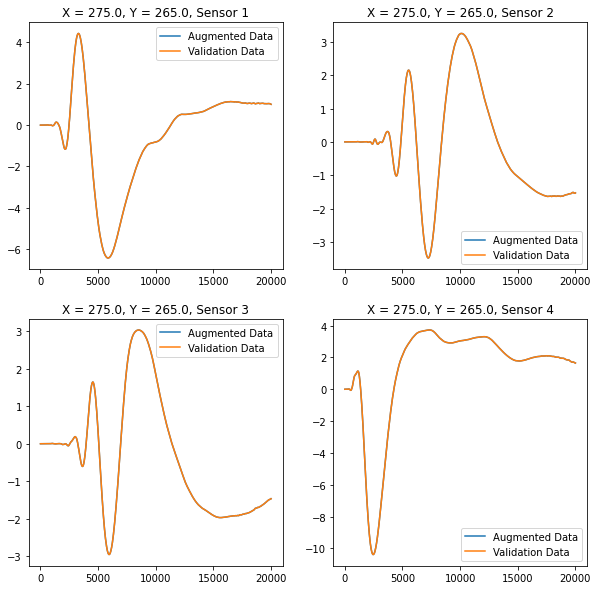

In [15]:
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
ax1.plot(checkAugData[0]['Sensor 1'])
ax1.plot(valAug_data[0]['Sensor 1'])
ax1.legend(['Augmented Data','Validation Data'])
ax1.set_title('X = '+str(checkAugData[0].iloc[0,5])+', '+'Y = '+str(checkAugData[0].iloc[0,6])+', '+'Sensor 1')
ax2.plot(checkAugData[0]['Sensor 2'])
ax2.plot(valAug_data[0]['Sensor 2'])
ax2.legend(['Augmented Data','Validation Data'])
ax2.set_title('X = '+str(checkAugData[0].iloc[0,5])+', '+'Y = '+str(checkAugData[0].iloc[0,6])+', '+'Sensor 2')
ax3.plot(checkAugData[0]['Sensor 3'])
ax3.plot(valAug_data[0]['Sensor 3'])
ax3.legend(['Augmented Data','Validation Data'])
ax3.set_title('X = '+str(checkAugData[0].iloc[0,5])+', '+'Y = '+str(checkAugData[0].iloc[0,6])+', '+'Sensor 3')
ax4.plot(checkAugData[0]['Sensor 4'])
ax4.plot(valAug_data[0]['Sensor 4'])
ax4.legend(['Augmented Data','Validation Data'])
ax4.set_title('X = '+str(checkAugData[0].iloc[0,5])+', '+'Y = '+str(checkAugData[0].iloc[0,6])+', '+'Sensor 4')
plt.show()    

fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
ax1.plot(checkAugData[1]['Sensor 1'])
ax1.plot(valAug_data[1]['Sensor 1'])
ax1.legend(['Augmented Data','Validation Data'])
ax1.set_title('X = '+str(checkAugData[1].iloc[0,5])+', '+'Y = '+str(checkAugData[1].iloc[0,6])+', '+'Sensor 1')
ax2.plot(checkAugData[1]['Sensor 2'])
ax2.plot(valAug_data[1]['Sensor 2'])
ax2.legend(['Augmented Data','Validation Data'])
ax2.set_title('X = '+str(checkAugData[1].iloc[0,5])+', '+'Y = '+str(checkAugData[1].iloc[0,6])+', '+'Sensor 2')
ax3.plot(checkAugData[1]['Sensor 3'])
ax3.plot(valAug_data[1]['Sensor 3'])
ax3.legend(['Augmented Data','Validation Data'])
ax3.set_title('X = '+str(checkAugData[1].iloc[0,5])+', '+'Y = '+str(checkAugData[1].iloc[0,6])+', '+'Sensor 3')
ax4.plot(checkAugData[1]['Sensor 4'])
ax4.plot(valAug_data[1]['Sensor 4'])
ax4.legend(['Augmented Data','Validation Data'])
ax4.set_title('X = '+str(checkAugData[0].iloc[0,5])+', '+'Y = '+str(checkAugData[0].iloc[0,6])+', '+'Sensor 4')
plt.show()   

fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
ax1.plot(checkAugData[2]['Sensor 1'])
ax1.plot(valAug_data[2]['Sensor 1'])
ax1.legend(['Augmented Data','Validation Data'])
ax1.set_title('X = '+str(checkAugData[2].iloc[0,5])+', '+'Y = '+str(checkAugData[2].iloc[0,6])+', '+'Sensor 1')
ax2.plot(checkAugData[2]['Sensor 2'])
ax2.plot(valAug_data[2]['Sensor 2'])
ax2.legend(['Augmented Data','Validation Data'])
ax2.set_title('X = '+str(checkAugData[2].iloc[0,5])+', '+'Y = '+str(checkAugData[2].iloc[0,6])+', '+'Sensor 2')
ax3.plot(checkAugData[2]['Sensor 3'])
ax3.plot(valAug_data[2]['Sensor 3'])
ax3.legend(['Augmented Data','Validation Data'])
ax3.set_title('X = '+str(checkAugData[2].iloc[0,5])+', '+'Y = '+str(checkAugData[2].iloc[0,6])+', '+'Sensor 3')
ax4.plot(checkAugData[2]['Sensor 4'])
ax4.plot(valAug_data[2]['Sensor 4'])
ax4.legend(['Augmented Data','Validation Data'])
ax4.set_title('X = '+str(checkAugData[2].iloc[0,5])+', '+'Y = '+str(checkAugData[2].iloc[0,6])+', '+'Sensor 4')
plt.show()   

fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
ax1.plot(checkAugData[3]['Sensor 1'])
ax1.plot(valAug_data[3]['Sensor 1'])
ax1.legend(['Augmented Data','Validation Data'])
ax1.set_title('X = '+str(checkAugData[3].iloc[0,5])+', '+'Y = '+str(checkAugData[3].iloc[0,6])+', '+'Sensor 1')
ax2.plot(checkAugData[3]['Sensor 2'])
ax2.plot(valAug_data[3]['Sensor 2'])
ax2.legend(['Augmented Data','Validation Data'])
ax2.set_title('X = '+str(checkAugData[3].iloc[0,5])+', '+'Y = '+str(checkAugData[3].iloc[0,6])+', '+'Sensor 2')
ax3.plot(checkAugData[3]['Sensor 3'])
ax3.plot(valAug_data[3]['Sensor 3'])
ax3.legend(['Augmented Data','Validation Data'])
ax3.set_title('X = '+str(checkAugData[3].iloc[0,5])+', '+'Y = '+str(checkAugData[3].iloc[0,6])+', '+'Sensor 3')
ax4.plot(checkAugData[3]['Sensor 4'])
ax4.plot(valAug_data[3]['Sensor 4'])
ax4.legend(['Augmented Data','Validation Data'])
ax4.set_title('X = '+str(checkAugData[3].iloc[0,5])+', '+'Y = '+str(checkAugData[3].iloc[0,6])+', '+'Sensor 4')
plt.show()

# fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows = 2, ncols = 2, figsize = (10,10))
# ax1.plot(checkAugData[0]['Sensor 4'])
# ax1.plot(valAug_data[0]['Sensor 4'])
# ax1.legend(['Augmented Data','Validation Data'])
# ax1.set_title('X = '+str(checkAugData[0].iloc[0,5])+', '+'Y = '+str(checkAugData[0].iloc[0,6])+', '+'Sensor 4')
# #plt.show()  

# ax2.plot(checkAugData[1]['Sensor 4'])
# ax2.plot(valAug_data[1]['Sensor 4'])
# ax2.legend(['Augmented Data','Validation Data'])
# ax2.set_title('X = '+str(checkAugData[1].iloc[0,5])+', '+'Y = '+str(checkAugData[1].iloc[0,6])+', '+'Sensor 4')
# #plt.show() 

# ax3.plot(checkAugData[2]['Sensor 4'])
# ax3.plot(valAug_data[2]['Sensor 4'])
# ax3.legend(['Augmented Data','Validation Data'])
# ax3.set_title('X = '+str(checkAugData[2].iloc[0,5])+', '+'Y = '+str(checkAugData[2].iloc[0,6])+', '+'Sensor 4')
# #plt.show() 

# ax4.plot(checkAugData[3]['Sensor 4'])
# ax4.plot(valAug_data[3]['Sensor 4'])
# ax4.legend(['Augmented Data','Validation Data'])
# ax4.set_title('X = '+str(checkAugData[3].iloc[0,5])+', '+'Y = '+str(checkAugData[3].iloc[0,6])+', '+'Sensor 4')
# plt.show() 

<h3>Cutting the numerical data till the highest peaks and resampling</h3>

In [16]:
dataNum = 1000 # number of datapoints in numerical data
finalNumData = np.zeros((numSimData.shape[0],dataNum,numSimData.shape[2]))
for ii in range(0,numSimData.shape[0]):
    finalNumData[ii,:,:] = dataSegment(numSimData[ii,:,:],dataNum)

# for ii in range(0,numSimData.shape[0]):
#     finalNumData[ii,:,1:5] = signal.resample(numSimData[ii,:,1:5],dataNum) # Resampling sensor Values
    
#     if numSimData.shape[0] > dataNum:
#         finalNumData[ii,:,5:] = numSimData[ii,:dataNum,5:] # Impact Locations
        
#     else:
#         finalNumData[ii,:,5:] = numSimData[ii,0,5:]*np.ones((dataNum,1))
        
#     finalNumData[ii,:,0] = np.linspace(numSimData[ii,0,0],numSimData[ii,-1,0],dataNum) # Time Vector

<h3> Plotting a sample cut data for visualisation: </h3>

Text(0, 0.5, 'Normalised Sensor Data')

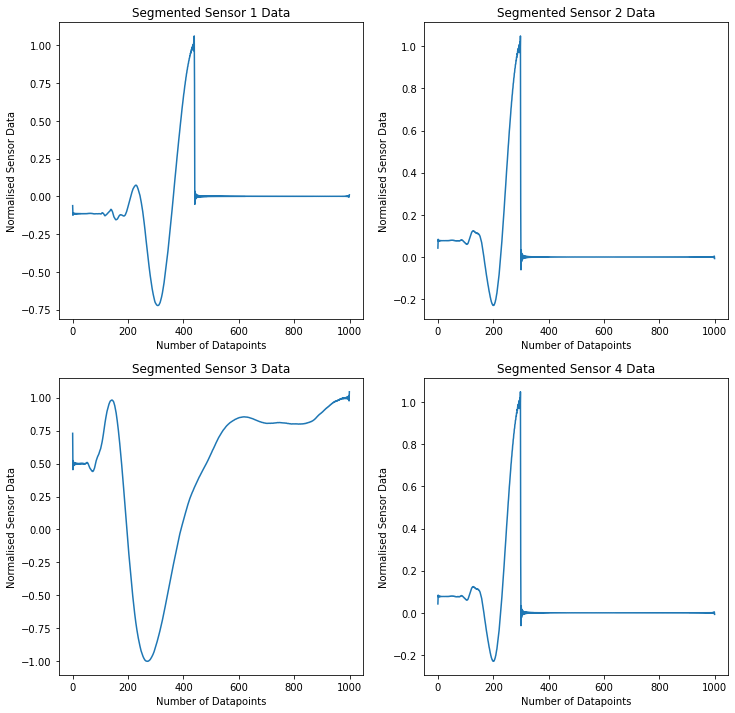

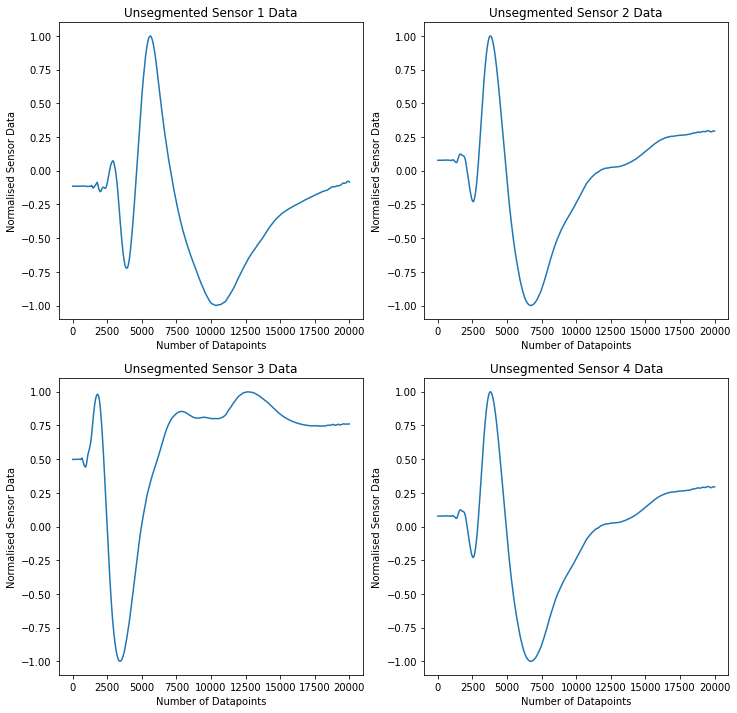

In [17]:
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows = 2, ncols = 2, figsize = (12,12))
num = 10 # File number
ax1.plot(finalNumData[num,:,1])
ax1.set_title('Segmented Sensor 1 Data')
ax1.set_xlabel('Number of Datapoints')
ax1.set_ylabel('Normalised Sensor Data')
ax2.plot(finalNumData[num,:,2])
ax2.set_title('Segmented Sensor 2 Data')
ax2.set_xlabel('Number of Datapoints')
ax2.set_ylabel('Normalised Sensor Data')
ax3.plot(finalNumData[num,:,3])
ax3.set_title('Segmented Sensor 3 Data')
ax3.set_xlabel('Number of Datapoints')
ax3.set_ylabel('Normalised Sensor Data')
ax4.plot(finalNumData[num,:,4])
ax4.set_title('Segmented Sensor 4 Data')
ax4.set_xlabel('Number of Datapoints')
ax4.set_ylabel('Normalised Sensor Data')

fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows = 2, ncols = 2, figsize = (12,12))
ax1.plot(numSimData[num,:,1])
ax1.set_title('Unsegmented Sensor 1 Data')
ax1.set_xlabel('Number of Datapoints')
ax1.set_ylabel('Normalised Sensor Data')
ax2.plot(numSimData[num,:,2])
ax2.set_title('Unsegmented Sensor 2 Data')
ax2.set_xlabel('Number of Datapoints')
ax2.set_ylabel('Normalised Sensor Data')
ax3.plot(numSimData[num,:,3])
ax3.set_title('Unsegmented Sensor 3 Data')
ax3.set_xlabel('Number of Datapoints')
ax3.set_ylabel('Normalised Sensor Data')
ax4.plot(numSimData[num,:,4])
ax4.set_title('Unsegmented Sensor 4 Data')
ax4.set_xlabel('Number of Datapoints')
ax4.set_ylabel('Normalised Sensor Data')

# fig = plt.figure(figsize = (6,6))
# plt.plot(numSimData[num,:,4])
# plt.title('Unsegmented Sensor 4 Data')
# plt.xlabel('Number of Datapoints',fontsize = 12)
# plt.ylabel('Normalised Sensor Data',fontsize = 12)
# plt.grid()

# fig = plt.figure(figsize = (6,6))
# plt.plot(finalNumData[num,:,4])
# plt.title('Segmented Sensor 4 Data')
# plt.xlabel('Number of Datapoints',fontsize = 12)
# plt.ylabel('Normalised Sensor Data',fontsize = 12)
# plt.grid()



<h2> Parsing Experimental Validation Data</h2>

Unlike the numerical data, the experimental data is given as text files, which need to be parsed line by line by the code.

In [18]:
files = oc.list(directory[2], depth = 'infinity')


for file in files:
    if not file.is_dir():
        # going through each text file
        # Downloading each text file
        
        content = oc.get_file(file.get_path()+ '/' + file.get_name()) # Downloadinf the file
        
        # Reading each text file
        
        # File format of each experimental data text file
        # File:    C:\exports\piezo_171.txt
        # Created: Freitag, 17. Dezember 2021 14:27:58
        # Header time format: Absolute
        # Time of first sample: 351 14:27:50.745076300
        # Title:   

        # Time	Ch A1	Ch A2	Ch A3	Ch A4
        # s	V	V	V	V
        
        # The first 8 lines have to be skipped and are not important
        # The first entry of the time series is the 9th line
        # We start reading from the 9th line (8th Index Number)
        
        f = open(file.get_name(),'r')
        contents = f.readlines() # readlines() returns the entire line as a single string
        # The multiple lines are thus returned as multiple strings, all part of a list
        contents = contents[8:]
        
        expT = [] # Empty list for storing time vector of each reading
        expS1 = [] # Empty list for storing sensor 1 reading 
        expS2 = [] # Empty list for storing sensor 2 reading
        expS3 = [] # Empty list for storing sensor 3 reading
        expS4 = [] # Empty list for storing sensor 4 reading
        expData = []
        X = []
        Y = []
        
        for i in range(0,len(contents)): # going through each line string
            
            # Each line contains the '\n' character at the end to signify the next line
            # Removing '\n' from each line string
            contents[i] = contents[i].replace('\n','') # repalce() doesn't modify the original list implicitly
            
            # The decimals in the file are written as commas which may create problems
            # Replacing all the commas with decimal points
            # replace(oldString, newString, # times the replacement has to be carried out)
            contents[i] = contents[i].replace(',','.',contents[i].count(','))
            
            
            # Each line string now has to be split with '\t' as the splitting tool
            # split() will split each line string wrt '\t' and return a list of the splitted strings
            # for each line
            # First split string -> Time vector element
            expT.append(float(contents[i].split('\t')[0]))
            # Second split string -> Sensor 1 reading
            expS1.append(float(contents[i].split('\t')[1]))
            # Third split string -> Sensor 2 reading
            expS2.append(float(contents[i].split('\t')[2]))

            # Fifth split string -> Sensor 3 reading
            expS3.append(float(contents[i].split('\t')[4]))

            # Fourth split string -> Sensor 4 reading
            expS4.append(float(contents[i].split('\t')[3]))
            
            # Impact Location X Coordinate
            X.append(int(file.get_name().split('_')[2]))
            
            # Impact Location Y Coordinate
            Y.append(int(file.get_name().split('_')[3]))


        
        f.close() # Closing the access to the text file
        colNames = ['Time', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4','X','Y']
        txt_df = pd.DataFrame(columns = colNames)
        
        txt_df['Time'] = expT
        # expS1 = dataFilter(expS1,4,10000,len(expS1)/expT[-1])
        # expS2 = dataFilter(expS1,4,10000,len(expS2)/expT[-1])
        # expS3 = dataFilter(expS1,4,10000,len(expS3)/expT[-1])
        # expS4 = dataFilter(expS1,4,10000,len(expS4)/expT[-1])
        txt_df['Sensor 1'] = expS1
        txt_df['Sensor 2'] = expS2
        txt_df['Sensor 3'] = expS3
        txt_df['Sensor 4'] = expS4
        
        txt_df['X'] = X
        txt_df['Y'] = Y
        
        
        # Deleting the read text file from local directory
        os.remove(file.get_name())
        
        
        
        # content = oc.get_file(directory[1] + 'SE1_a_t/' + file.get_name())
        # Loading the .text file
        # os.remove(file.get_name()) # Removing the file from the local directory once it has been read
    
        # Appending the dataframe correspnding to each file to the experimental data list
        exp_data.append(txt_df)
        
exp_data = np.array(exp_data)
        

<h3> Visualising raw experimental data</h3>

Text(0, 0.5, 'Sensor Raw Data')

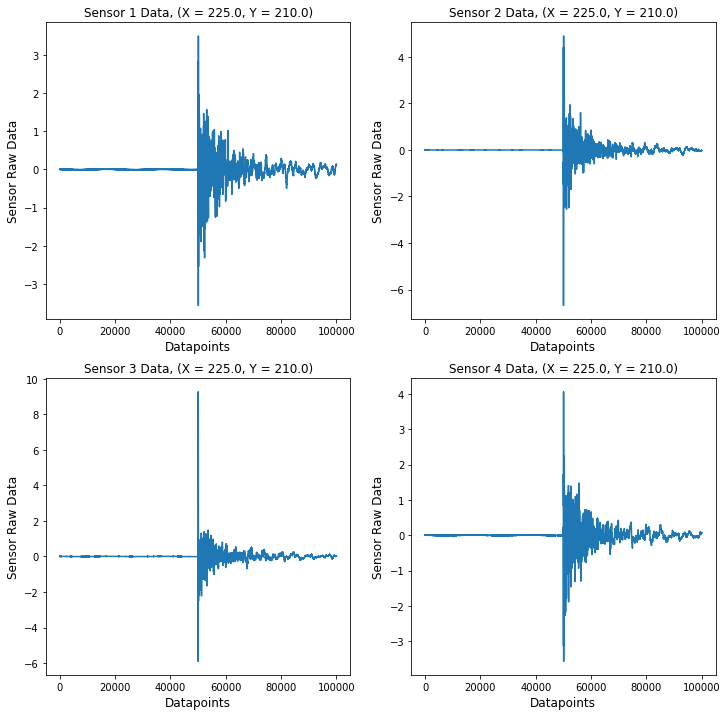

In [19]:
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows = 2, ncols = 2, figsize = (12,12))
num = 14 # File number
ax1.plot(exp_data[num,:,1])
ax1.set_title('Sensor 1 Data, (X = '+str(exp_data[num,0,5])+', Y = '+str(exp_data[num,0,6])+')')
ax1.set_xlabel('Datapoints',fontsize = 12)
ax1.set_ylabel('Sensor Raw Data',fontsize = 12)
ax2.plot(exp_data[num,:,2])
ax2.set_xlabel('Datapoints',fontsize = 12)
ax2.set_title('Sensor 2 Data, (X = '+str(exp_data[num,0,5])+', Y = '+str(exp_data[num,0,6])+')')
ax2.set_ylabel('Sensor Raw Data',fontsize = 12)
ax3.plot(exp_data[num,:,3])
ax3.set_title('Sensor 3 Data, (X = '+str(exp_data[num,0,5])+', Y = '+str(exp_data[num,0,6])+')')
ax3.set_xlabel('Datapoints',fontsize = 12)
ax3.set_ylabel('Sensor Raw Data',fontsize = 12)
ax4.plot(exp_data[num,:,4])
ax4.set_title('Sensor 4 Data, (X = '+str(exp_data[num,0,5])+', Y = '+str(exp_data[num,0,6])+')')
ax4.set_xlabel('Datapoints',fontsize = 12)
ax4.set_ylabel('Sensor Raw Data',fontsize = 12)

# fig = plt.figure(figsize = (6,6))
# plt.plot(exp_data[num,:,4])
# plt.title('Sensor 4 Data, (X = '+str(exp_data[num,0,5])+', Y = '+str(exp_data[num,0,6])+')')
# plt.xlabel('Datapoints',fontsize = 12)
# plt.ylabel('Sensor Raw Data',fontsize = 12)
# plt.grid()



<h3>Cutting garbage experimental data</h3>

In [20]:
# Cutting Garbage Data
for ii in range(0,exp_data.shape[0]):
    dataCut = expDataSegment(exp_data[ii,:,:])
    dataCut[:,1:5] = -dataCut[:,1:5]
    expData.append(dataCut) # Inverting the Experimental Data
                
expData = np.array(expData, dtype = object)

<h3>Normalising Experimental Data</h3>

In [21]:
# expData = dataNormal(expData) 

# Using MinMaxScaler method
for i in range(0,expData.shape[0]):
    expData[i,:,1:5] = MinMaxScaler(feature_range = (-1,1)).fit_transform(expData[i,:,1:5]) # Normalising between -1 and 1

<h3>Resampling Experimental data to same number of datapoints as the numerical data and cutting it after the highest peak</h3>

In [22]:
finalexpData = np.zeros((expData.shape[0],dataNum,7))
for ii in range(0,expData.shape[0]):
    finalexpData[ii,:,:] = dataSegment(expData[ii,:,:],dataNum)

# for ii in range(0,expData.shape[0]):
#     finalexpData[ii,:,1:5] = signal.resample(expData[ii,:,1:5],dataNum) # Resampling sensor Values
    
#     if expData.shape[0] > dataNum:
#         finalexpData[ii,:,5:] = expData[ii,:dataNum,5:] # Impact Locations
        
#     else:
#         finalexpData[ii,:,5:] = expData[ii,0,5:]*np.ones((dataNum,1))
        
#     finalexpData[ii,:,0] = np.linspace(expData[ii,0,0],expData[ii,-1,0],dataNum) # Time Vector


<h3> Visualising segmented and processed experimental data</h3>

Text(0, 0.5, 'Sensor Data')

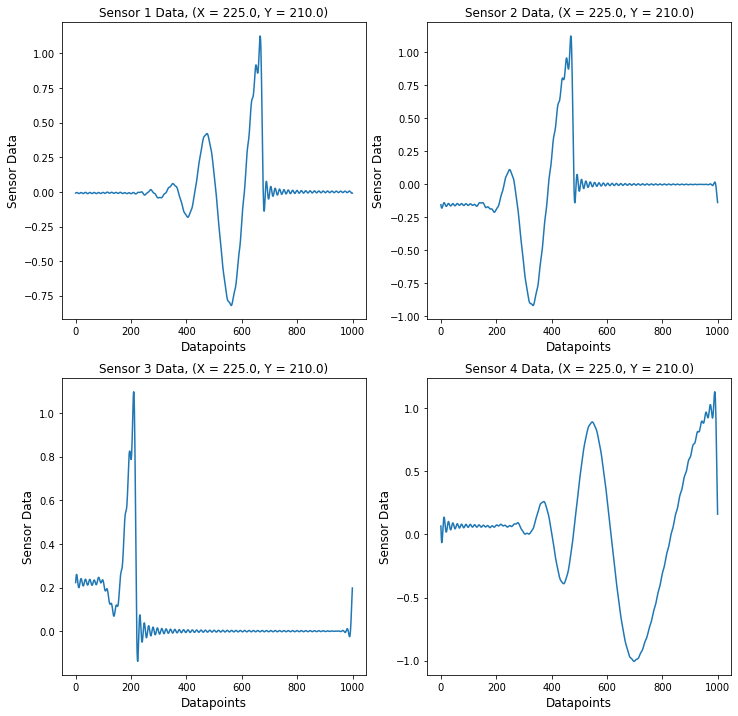

In [23]:
fig, ([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows = 2, ncols = 2, figsize = (12,12))
num = 14 # File number
ax1.plot(finalexpData[num,:,1])
ax1.set_title('Sensor 1 Data, (X = '+str(finalexpData[num,0,5])+', Y = '+str(finalexpData[num,0,6])+')')
ax1.set_xlabel('Datapoints',fontsize = 12)
ax1.set_ylabel('Sensor Data',fontsize = 12)
ax2.plot(finalexpData[num,:,2])
ax2.set_xlabel('Datapoints',fontsize = 12)
ax2.set_title('Sensor 2 Data, (X = '+str(finalexpData[num,0,5])+', Y = '+str(finalexpData[num,0,6])+')')
ax2.set_ylabel('Sensor Data',fontsize = 12)
ax3.plot(finalexpData[num,:,3])
ax3.set_title('Sensor 3 Data, (X = '+str(finalexpData[num,0,5])+', Y = '+str(finalexpData[num,0,6])+')')
ax3.set_xlabel('Datapoints',fontsize = 12)
ax3.set_ylabel('Sensor Data',fontsize = 12)
ax4.plot(finalexpData[num,:,4])
ax4.set_title('Sensor 4 Data, (X = '+str(finalexpData[num,0,5])+', Y = '+str(finalexpData[num,0,6])+')')
ax4.set_xlabel('Datapoints',fontsize = 12)
ax4.set_ylabel('Sensor Data',fontsize = 12)

# fig = plt.figure(figsize = (6,6))
# plt.plot(finalexpData[num,:,4])
# plt.title('Sensor 4 Data, (X = '+str(finalexpData[num,0,5])+', Y = '+str(finalexpData[num,0,6])+')')
# plt.xlabel('Datapoints',fontsize = 12)
# plt.ylabel('Sensor Data',fontsize = 12)
# plt.grid()

<h2>Comparing Experimental and Numerical Data for a particular Impact Location</h2>

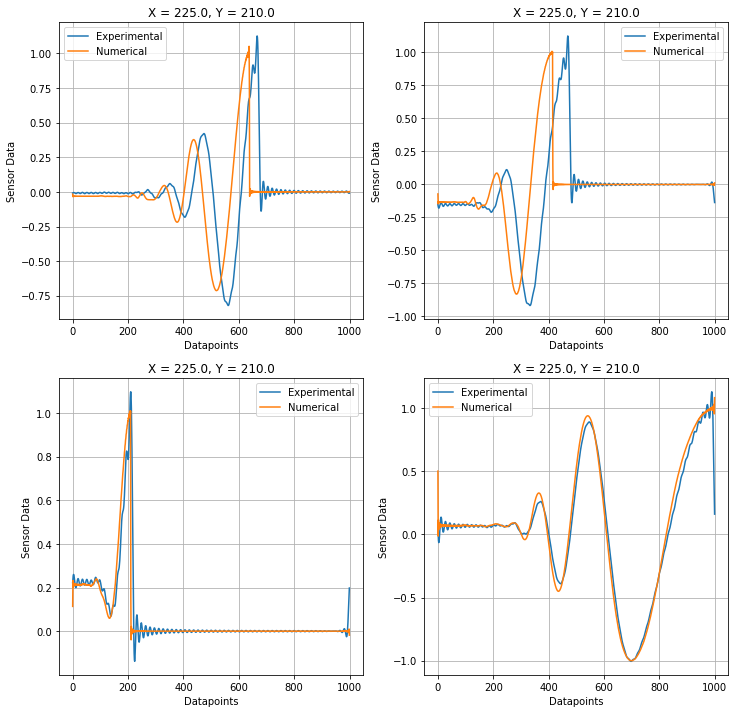

In [24]:
expfileNum = 14
for i in range(0,numSimData.shape[0]):
    if finalNumData[i,0,5] == finalexpData[expfileNum,0,5] and finalNumData[i,0,6] == finalexpData[expfileNum,0,6]:
        expDataCompare = finalNumData[i,:,:]
        match = i
        

fig,([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows = 2, ncols = 2, figsize = (12,12))
ax1.plot(finalexpData[expfileNum,:,1], label = 'Experimental')
ax1.plot(expDataCompare[:,1], label = 'Numerical')
ax1.legend()
ax1.set_xlabel('Datapoints')
ax1.set_ylabel('Sensor Data')
ax1.set_title('X = '+str(finalexpData[expfileNum,0,5])+', Y = '+str(finalexpData[expfileNum,0,6]))
ax1.grid()
ax2.plot(finalexpData[expfileNum,:,2], label = 'Experimental')
ax2.plot(expDataCompare[:,2], label = 'Numerical')
ax2.legend()
ax2.set_xlabel('Datapoints')
ax2.set_ylabel('Sensor Data')
ax2.set_title('X = '+str(finalexpData[expfileNum,0,5])+', Y = '+str(finalexpData[expfileNum,0,6]))
ax2.grid()
ax3.plot(finalexpData[expfileNum,:,3], label = 'Experimental')
ax3.plot(expDataCompare[:,3], label = 'Numerical')
ax3.legend()
ax3.set_xlabel('Datapoints')
ax3.set_ylabel('Sensor Data')
ax3.set_title('X = '+str(finalexpData[expfileNum,0,5])+', Y = '+str(finalexpData[expfileNum,0,6]))
ax3.grid()
ax4.plot(finalexpData[expfileNum,:,4], label = 'Experimental')
ax4.plot(expDataCompare[:,4], label = 'Numerical')
ax4.legend()
ax4.set_xlabel('Datapoints')
ax4.set_ylabel('Sensor Data')
ax4.set_title('X = '+str(finalexpData[expfileNum,0,5])+', Y = '+str(finalexpData[expfileNum,0,6]))
ax4.grid()
plt.show()

# fig,([ax1,ax2],[ax3,ax4]) = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
# ax1.plot(finalexpData[expfileNum,:,0] - finalexpData[expfileNum,0,0],finalexpData[expfileNum,:,1], label = 'Experimental')
# ax1.plot(expDataCompare[:,0], expDataCompare[:,1], label = 'Numerical')
# ax1.legend()
# ax1.set_title('X = '+str(finalexpData[expfileNum,0,5])+', Y = '+str(finalexpData[expfileNum,0,6]))
# ax2.plot(finalexpData[expfileNum,:,0] - finalexpData[expfileNum,0,0], finalexpData[expfileNum,:,2], label = 'Experimental')
# ax2.plot(expDataCompare[:,0],expDataCompare[:,2], label = 'Numerical')
# ax2.legend()
# ax2.set_title('X = '+str(finalexpData[expfileNum,0,5])+', Y = '+str(finalexpData[expfileNum,0,6]))
# ax3.plot(finalexpData[expfileNum,:,0] - finalexpData[expfileNum,0,0], finalexpData[expfileNum,:,3], label = 'Experimental')
# ax3.plot(expDataCompare[:,0],expDataCompare[:,3], label = 'Numerical')
# ax3.legend()
# ax3.set_title('X = '+str(finalexpData[expfileNum,0,5])+', Y = '+str(finalexpData[expfileNum,0,6]))
# ax4.plot(finalexpData[expfileNum,:,0] - finalexpData[expfileNum,0,0], finalexpData[expfileNum,:,4], label = 'Experimental')
# ax4.plot(expDataCompare[:,0],expDataCompare[:,4], label = 'Numerical')
# ax4.legend()
# ax4.set_title('X = '+str(finalexpData[expfileNum,0,5])+', Y = '+str(finalexpData[expfileNum,0,6]))
# plt.show()

# fig = plt.figure(figsize = (6,6))
# plt.plot(finalexpData[expfileNum,:,4], label = 'Experimental')
# plt.plot(expDataCompare[:,4], label = 'Numerical')
# plt.legend()
# plt.xlabel('Datapoints',fontsize = 12)
# plt.ylabel('Sensor Data',fontsize = 12)
# plt.title('X = '+str(finalexpData[expfileNum,0,5])+', Y = '+str(finalexpData[expfileNum,0,6]))
# plt.grid()
# plt.show()




<h2> Saving Numerical and Experimental Validation Data </h2>

We don't want to parse the data again and again since it takes a lot of time

In [64]:
# Preprocessed experimental validation data
finalexpData_rshpd = finalexpData.reshape(finalexpData.shape[0], -1)
np.savetxt('saved_variables/finalexpData.txt',finalexpData_rshpd)

# Preprocessed numerical simulation data
finalNumData_rshpd = finalNumData.reshape(finalNumData.shape[0], -1)
np.savetxt('saved_variables/finalNumData.txt',finalNumData_rshpd)

<h3> Splitting Numerical and Experimental Data into Sensor Sets for X and Y coordinates </h3>

All sensor data is used to predict the X and Y locations. The output array consists of the impact locations and is stored as a $1\times2$ array.

The entire numerical data will be considered for the training and validation data, while only half of the experimental validation data is considered for validation and training data.

In [25]:
Sxy1 = finalNumData[:,:,1:5] # Sensor Numerical Data
Sxy2 = finalexpData[:12,:,1:5] # Half of experimental data
Sxy = np.concatenate((Sxy1,Sxy2),axis = 0)
#Sxy = Sxy.reshape(-1,4*dataNum,1) # Reshaping
Oxy1 = finalNumData[:,0,5:] # Impact Locations in Numerical Data
Oxy2 = finalexpData[:12,0,5:] # Impact Locations in Experimental Data
Oxy = np.concatenate((Oxy1,Oxy2),axis = 0) # Training and Validation Data outputs

In [26]:
Oxy.shape,Oxy1.shape,Oxy2.shape, Sxy.shape, Sxy1.shape, Sxy2.shape

((988, 2), (976, 2), (12, 2), (988, 1000, 4), (976, 1000, 4), (12, 1000, 4))

<h3> Splitting Sensor Data into Training and Validation Data </h3>

90% of the data is kept as Training Data and 10% of the data is kept as the Validation Data.

In [27]:
Sxy_train, Sxy_val, Oxy_train, Oxy_val = train_test_split(Sxy, Oxy, test_size=0.1, shuffle=True)

<h3>Test Data</h3>

The remaining half of the experimental validation data will be the test data on which the trained and validated neural network will be tested.

In [28]:
Sxy_test = finalexpData[12:,:,1:5] # Sensor Experimental Data
#Sxy_test = Sxy_test.reshape(-1,4*dataNum,1) # Reshaping
Oxy_test = finalexpData[12:,0,5:] # Impact Locations

In [29]:
print(Sxy_val.shape,Oxy_train.shape,Sxy_test.shape,Oxy_test.shape)

(99, 1000, 4) (889, 2) (12, 1000, 4) (12, 2)


In [30]:
# Converting all datatype to float 32
Sxy_train = Sxy_train.astype('float32')
Sxy_val = Sxy_val.astype('float32')
Sxy_test = Sxy_test.astype('float32')
Oxy_train = Oxy_train.astype('float32')
Oxy_val = Oxy_val.astype('float32')
Oxy_test = Oxy_test.astype('float32')
Oxy_test = Oxy_test.astype('float32')

<h3>Normalisation of Impact Locations (for Regression Problem)</h3>

The impact locations in the data going inside the Neural Network is normalised with respect to the original Training and Validation Data i.e. based on the maximum coordinates in the original numerical and experimental data, the training, validation and test data will be scaled.

Since we input normalised data into the Neural Network, the model will give out normalised outputs which need to be denormalised in order to be compared with the impact location coordinates of the test data.

In [31]:
Oxy_scale = MinMaxScaler().fit(Oxy)
# Oxy_train_n = MinMaxScaler(feature_range = (0.1,0.9)).fit_transform(Oxy_train)
Oxy_train_n = Oxy_scale.transform(Oxy_train)
Oxy_val_n = Oxy_scale.transform(Oxy_val)
# Oxy_val_n = MinMaxScaler(feature_range = (0.1,0.9)).fit_transform(Oxy_val)
# Oxy_test_n = MinMaxScaler(feature_range = (0.3,0.7)).fit_transform(Oxy_test)]
Oxy_test_n = Oxy_scale.transform(Oxy_test)

In [32]:
print(Oxy_val_n[0], np.max(Oxy_train_n[:,1]), np.max(Oxy_val_n[:,1]),np.max(Oxy_test_n[:,1]))

[0.30000004 0.6666667 ] 1.0000001 1.0000001 0.53333336


<h3> Saving the Test Data variables locally for later usage </h3>

In [33]:
# Training and Validation Data outputs
# 2D array
np.savetxt('saved_variables/Oxy.txt',Oxy)

# Testing Data outputs
# 2D array
np.savetxt('saved_variables/Oxy_test.txt',Oxy_test)

# Normalised Testing Data outputs
# 2D array
np.savetxt('saved_variables/Oxy_test_n.txt',Oxy_test_n)

# Sensor Test Data
# Reshaping 3D arrays to 2D arrays
Sxy_test_rshpd = Sxy_test.reshape(Sxy_test.shape[0], -1)
np.savetxt('saved_variables/Sxy_test.txt',Sxy_test_rshpd)

# Training and Validation sensor data
# Reshaping 3D arrays to 2D arrays
Sxy_rshpd = Sxy.reshape(Sxy.shape[0], -1)
np.savetxt('saved_variables/Sxy.txt',Sxy_rshpd)



In [34]:
# # Verification that reshaping is not modifying the array
# Sxy_test_load = np.loadtxt('saved_variables/Sxy_test.txt')

# # Sxy_test_load is a 2D array
# Sxy_test_comp = Sxy_test_load.reshape(
#     Sxy_test_load.shape[0], Sxy_test_load.shape[1] // Sxy_test.shape[2], Sxy_test.shape[2])

# print(Sxy_test_comp.shape,Sxy_test.shape)

# # check if both arrays are same or not:
# if (Sxy_test_comp == Sxy_test).all():
#     print("Yes, both the arrays are same")
# else:
#     print("No, both the arrays are not same")

<h2> Implementing Convolutional Neural Network </h2>

In [35]:
# Number of Epochs
epochs = 100

<h3>Ensuring Consistent Results by the Neural Network</h3>

In [36]:
seed(1)
tf.random.set_seed(1)

<h3> CNN Model for X and Y impact location prediction </h3>

In [37]:
model_xy = Sequential()
model_xy.add(Conv1D(16, kernel_size=8, kernel_initializer='he_uniform', strides=1, padding='causal', activation='relu', input_shape=(dataNum,4)))
#model_xy.add(Conv1D(16, kernel_size=6, kernel_initializer='he_uniform', strides=4, padding='causal', activation='relu', input_shape=(4*dataNum,1)))
model_xy.add(LeakyReLU(alpha=0.1))
# model_xy.add(Dropout(0.95))
model_xy.add(AveragePooling1D(pool_size=10))
# model_xy.add(MaxPooling1D(pool_size=8))
model_xy.add(Conv1D(32, kernel_size=3, padding='causal', activation='linear'))
model_xy.add(LeakyReLU(alpha=0.1))
# model_xy.add(Dropout(0.95))
model_xy.add(MaxPooling1D(pool_size=5))
model_xy.add(Conv1D(64, kernel_size=2, padding='causal', activation='linear'))
model_xy.add(LeakyReLU(alpha=0.1))
# model_xy.add(Dropout(0.95))
model_xy.add(MaxPooling1D(pool_size=2))
model_xy.add(Flatten())
model_xy.add(Dense(128))
model_xy.add(LeakyReLU(alpha=0.1))
model_xy.add(Dropout(0.7))
model_xy.add(Dense(2))

# Compiling the CNN Model
model_xy.compile(loss="mean_squared_error", optimizer="adam", metrics=['mse','mae']) # for regression problem
# model_y.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]) # for classification problem

<h3> Summary of the Model </h3>

In [38]:
model_xy.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1000, 16)          528       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 1000, 16)          0         
_________________________________________________________________
average_pooling1d (AveragePo (None, 100, 16)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 32)           1568      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 100, 32)           0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 20, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 20, 64)            4

<h3>Visualising the Model</h3>

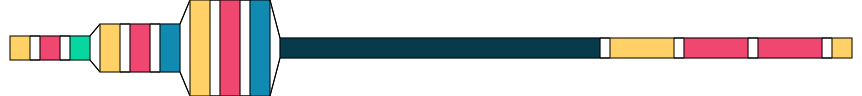

In [39]:
model = model_xy

visualkeras.layered_view(model, legend=False, draw_volume=False, scale_xy=1.5, scale_z=0.5, to_file='output1.png') #.show() # display using your system viewer
# visualkeras.layered_view(model, legend=True, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show

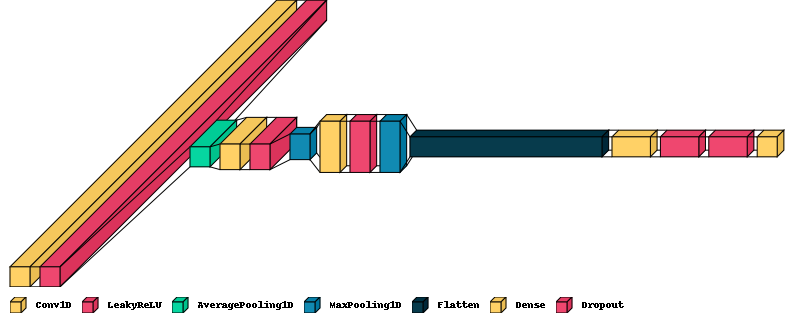

In [40]:
visualkeras.layered_view(model, legend=True, draw_volume=True, scale_xy=0.8, scale_z=0.3, to_file='output2.png') #.show() # display using your system viewer

<h3>Implementing early stopping by monitoring mean absolute error</h3>

In [41]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'mae', patience = 5)

<h3> Training the Model </h3>

In [42]:
model_train_xy = model_xy.fit(Sxy_train, Oxy_train_n, epochs=epochs, callbacks = [callback], verbose=1, validation_data = (Sxy_val, Oxy_val_n), shuffle = True) # With Validation

Epoch 1/100
28/28 [==============================] - 1s 17ms/step - loss: 0.1454 - mse: 0.1454 - mae: 0.2997 - val_loss: 0.0492 - val_mse: 0.0492 - val_mae: 0.1704
Epoch 2/100
28/28 [==============================] - 0s 12ms/step - loss: 0.0655 - mse: 0.0655 - mae: 0.2041 - val_loss: 0.0296 - val_mse: 0.0296 - val_mae: 0.1297
Epoch 3/100
28/28 [==============================] - 0s 10ms/step - loss: 0.0484 - mse: 0.0484 - mae: 0.1766 - val_loss: 0.0207 - val_mse: 0.0207 - val_mae: 0.1110
Epoch 4/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0400 - mse: 0.0400 - mae: 0.1580 - val_loss: 0.0170 - val_mse: 0.0170 - val_mae: 0.1023
Epoch 5/100
28/28 [==============================] - 0s 11ms/step - loss: 0.0355 - mse: 0.0355 - mae: 0.1500 - val_loss: 0.0167 - val_mse: 0.0167 - val_mae: 0.1029
Epoch 6/100
28/28 [==============================] - 0s 10ms/step - loss: 0.0342 - mse: 0.0342 - mae: 0.1458 - val_loss: 0.0138 - val_mse: 0.0138 - val_mae: 0.0947
Epoch 7/100
28/2

<h2> Saving the trained and validated model for consistent results </h2>

In [43]:
# Save the entire model as a SavedModel.
# !mkdir -p saved_model # (Terminal command)
model_xy.save('saved_model/cnn_model')

A subdirectory or file -p already exists.
Error occurred while processing: -p.
A subdirectory or file saved_model already exists.
Error occurred while processing: saved_model.


INFO:tensorflow:Assets written to: saved_model/cnn_model\assets


<h2> Reloading the trained and validated model </h2>

In [44]:
# For continuous testing, the code above this doesn't need to be executed again and again
model_xy = tf.keras.models.load_model('saved_model/cnn_model')

<h3> Reloading pertinent variables stored locally </h3>


In [45]:
# Training and Validation Data outputs
Oxy = np.loadtxt('saved_variables/Oxy.txt')

# Testing Data outputs
Oxy_test = np.loadtxt('saved_variables/Oxy_test.txt')

# Normalised Testing Data outputs
Oxy_test_n = np.loadtxt('saved_variables/Oxy_test_n.txt')

# Sensor Test Data
Sxy_test_load = np.loadtxt('saved_variables/Sxy_test.txt')

# Sxy_load is a 2D array
Sxy_test = Sxy_test_load.reshape(
    Sxy_test_load.shape[0], Sxy_test_load.shape[1] // 4, 4)

# print(Sxy_test_comp.shape,Sxy_test.shape)

# # check if both arrays are same or not:
# if (Sxy_test_comp == Sxy_test).all():
#     print("Yes, both the arrays are same")
# else:
#     print("No, both the arrays are not same")


In [46]:
Oxy_pred = model_xy.predict(Sxy_test) # For regression of Test Data
print(model_xy.evaluate(Sxy_test, Oxy_test_n)) 
print('MSE: %4f' %mean_squared_error(Oxy_test_n, Oxy_pred))
print('MAE: %4f' %mean_absolute_error(Oxy_test_n, Oxy_pred))

1/1 [==============================] - 0s 112ms/step - loss: 0.0068 - mse: 0.0068 - mae: 0.0704
[0.006802421063184738, 0.006802421063184738, 0.07035140693187714]
MSE: 0.006802
MAE: 0.070351


<h3> Denormalising the predicted impact locations</h3>

In [47]:
obj = MinMaxScaler().fit(Oxy)
Oxy_pred_DN = obj.inverse_transform(Oxy_pred)
np.round(Oxy_pred_DN), Oxy_test

(array([[220., 208.],
        [223., 200.],
        [225., 225.],
        [224., 226.],
        [244., 242.],
        [231., 240.],
        [221., 257.],
        [227., 244.],
        [320., 221.],
        [292., 227.],
        [315., 224.],
        [324., 218.]], dtype=float32),
 array([[225., 210.],
        [225., 210.],
        [225., 210.],
        [225., 210.],
        [240., 255.],
        [240., 255.],
        [240., 255.],
        [240., 255.],
        [300., 235.],
        [300., 235.],
        [300., 235.],
        [300., 235.]]))

In [48]:
print('MSE: %4f' %mean_squared_error(Oxy_pred_DN, Oxy_test))
print('MAE: %4f' %mean_absolute_error(Oxy_pred_DN, Oxy_test))

MSE: 153.054425
MAE: 10.552709


In [49]:
Oxy_pred.shape

(12, 2)

<h2>Plotting the predicted Impact Locations against the given locations for the test data</h2>

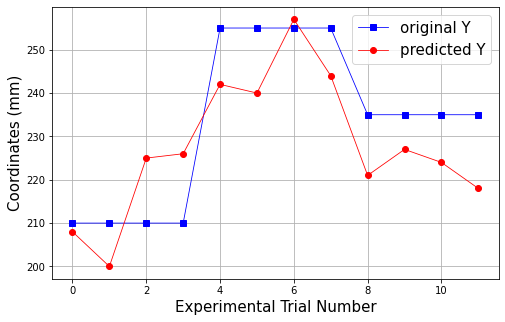

In [50]:
Sy_ax = range(Oxy_pred.shape[0])
fig = plt.figure(figsize = (8,5))
plt.plot(Sy_ax, Oxy_test[:,1], lw=0.8, color='blue',marker = 's', label='original Y')
plt.plot(Sy_ax, np.round(Oxy_pred_DN[:,1]), lw=0.8, color='red',marker = 'o', label='predicted Y')
plt.legend(prop = {'size' : 15})
plt.xlabel('Experimental Trial Number',fontsize = 15)
plt.ylabel('Coordinates (mm)',fontsize = 15)
plt.grid()
plt.show()

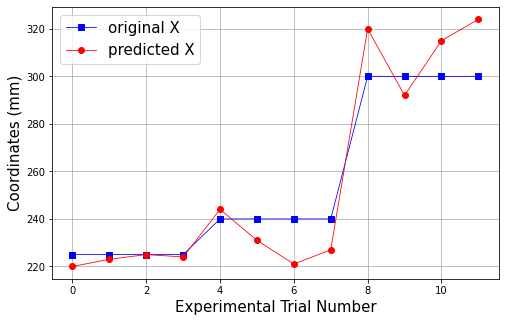

In [51]:
Sx_ax = range(Oxy_pred.shape[0])
fig = plt.figure(figsize = (8,5))
plt.plot(Sx_ax, Oxy_test[:,0], lw=0.8, color='blue',marker = 's', label='original X')
plt.plot(Sx_ax, np.round(Oxy_pred_DN[:,0]), lw=0.8, color='red',marker = 'o', label='predicted X')
plt.legend(prop = {'size' : 15})
plt.xlabel('Experimental Trial Number',fontsize = 15)
plt.ylabel('Coordinates (mm)',fontsize = 15)
plt.grid()
plt.show()

<h2>Group Specific Experimental Data (Prediction Data)</h2>

In [9]:
dataNum = 1000 # number of datapoints in numerical data
expData = []
exp_data = []

#%% Experimental Data (Group Specific)
files = oc1.list('/', depth = 'infinity')


for file in files:
    #if not file.is_dir():
    # going through each text file
    # Downloading each text file
    
    content = oc1.get_file(file.get_path() + file.get_name()) # Downloading the file
    
    # Reading each text file
    
    # File format of each experimental data text file
    # File:    C:\exports\piezo_171.txt
    # Created: Freitag, 17. Dezember 2021 14:27:58
    # Header time format: Absolute
    # Time of first sample: 351 14:27:50.745076300
    # Title:   

    # Time	Ch A1	Ch A2	Ch A3	Ch A4
    # s	V	V	V	V
    
    # The first 8 lines have to be skipped and are not important
    # The first entry of the time series is the 9th line
    # We start reading from the 9th line (8th Index Number)
    
    f = open(file.get_name(),'r')
    contents = f.readlines() # readlines() returns the entire line as a single string
    # The multiple lines are thus returned as multiple strings, all part of a list
    contents = contents[8:]
    
    expT = [] # Empty list for storing time vector of each reading
    expS1 = [] # Empty list for storing sensor 1 reading 
    expS2 = [] # Empty list for storing sensor 2 reading
    expS3 = [] # Empty list for storing sensor 3 reading
    expS4 = [] # Empty list for storing sensor 4 reading
    expData = []
    X = []
    Y = []
    
    for i in range(0,len(contents)): # going through each line string
        
        # Each line contains the '\n' character at the end to signify the next line
        # Removing '\n' from each line string
        contents[i] = contents[i].replace('\n','') # repalce() doesn't modify the original list implicitly
        
        # The decimals in the file are written as commas which may create problems
        # Replacing all the commas with decimal points
        # replace(oldString, newString, # times the replacement has to be carried out)
        contents[i] = contents[i].replace(',','.',contents[i].count(','))
        
        
        # Each line string now has to be split with '\t' as the splitting tool
        # split() will split each line string wrt '\t' and return a list of the splitted strings
        # for each line
        # First split string -> Time vector element
        expT.append(float(contents[i].split('\t')[0]))
        # Second split string -> Sensor 1 reading
        expS1.append(float(contents[i].split('\t')[1]))
        # Third split string -> Sensor 2 reading
        expS2.append(float(contents[i].split('\t')[2]))

        # Fourth split string -> Sensor 3 reading
        expS3.append(float(contents[i].split('\t')[4]))

        # Fifth split string -> Sensor 4 reading
        expS4.append(float(contents[i].split('\t')[3]))
        
#         # Impact Location X Coordinate
#         X.append(int(file.get_name().split('_')[2]))
            
#         # Impact Location Y Coordinate
#         Y.append(int(file.get_name().split('_')[3]))

        
        
        
        
    
    
    f.close() # Closing the access to the text file
    colNames = ['Time', 'Sensor 1', 'Sensor 2', 'Sensor 3', 'Sensor 4','X','Y']
    txt_df = pd.DataFrame(columns = colNames)
    
    txt_df['Time'] = expT
    # expS1 = dataFilter(expS1,4,10000,len(expS1)/expT[-1])
    # expS2 = dataFilter(expS1,4,10000,len(expS2)/expT[-1])
    # expS3 = dataFilter(expS1,4,10000,len(expS3)/expT[-1])
    # expS4 = dataFilter(expS1,4,10000,len(expS4)/expT[-1])
    txt_df['Sensor 1'] = expS1
    txt_df['Sensor 2'] = expS2
    txt_df['Sensor 3'] = expS3
    txt_df['Sensor 4'] = expS4
    
    
    # Deleting the read text file from local directory
    os.remove(file.get_name())
    
    
    
    # content = oc.get_file(directory[1] + 'SE1_a_t/' + file.get_name())
    # Loading the .text file
    # os.remove(file.get_name()) # Removing the file from the local directory once it has been read

    # Appending the dataframe correspnding to each file to the experimental data list
    exp_data.append(txt_df)
        
exp_data = np.array(exp_data)
        
#%% Final Experimental Validation Data
                
# Cutting Garbage Data
for ii in range(0,exp_data.shape[0]):
    dataCut = expDataSegment(exp_data[ii,:,:])
    dataCut[:,1:5] = -dataCut[:,1:5] # Inverting the Experimental Data
    expData.append(dataCut) 
                
expData = np.array(expData, dtype = object)

# Normalisation
# expData = dataNormal(expData)

# Using MinMaxScaler method
for i in range(0,expData.shape[0]):
    expData[i,:,1:5] = MinMaxScaler(feature_range = (-1,1)).fit_transform(expData[i,:,1:5]) # Normalising between -1 and 1

# Segmenting the data after highest peak
finalpredData = np.zeros((expData.shape[0],dataNum,7))
for ii in range(0,expData.shape[0]):
    finalpredData[ii,:,:] = dataSegment(expData[ii,:,:],dataNum)


In [10]:
finalpredData.shape

(18, 1000, 7)

<h3>Prediction Data</h3>

In [11]:
Sxy_pred = finalpredData[:,:,1:5]
#Sxy_pred = Sxy_pred.reshape(-1,4*dataNum,1) # Reshaping
Sxy_pred.shape

(18, 1000, 4)

<h3>Predicting impact locations for the experimental data</h3>

In [12]:
Oxy_PRED = model_xy.predict(Sxy_pred)
Oxy_PRED_DN = obj.inverse_transform(Oxy_PRED)
Oxy_PRED_DN = np.round(Oxy_PRED_DN)
Oxy_PRED_DN

NameError: name 'model_xy' is not defined

In [56]:
Oxy_PRED_DN.shape

(18, 2)

In [57]:
df_pred = pd.DataFrame(Oxy_PRED_DN)
df_pred.to_csv('predicted_test.csv')

<h3>Actual experimental data Impact Locations and comparison with model results</h3>

In [13]:
# Actual experimental impact locations
Oxy_act = np.array([[250,250],
[245,255],
[265,235],
[250,265],
[265,255],
[255,265],
[265,235],
[225,200],
[235,235],
[235,300],
[250,265],
[200,225],
[235,235],
[300,285],
[270,300],
[260,320],
[245,255],
[250,250]])

Oxy_act[1,1]


255

In [ ]:
# Normalising prediction data output


## Locally saving Prediction Data

In [14]:
# Actual Impact Locations (Desired Outputs)
# 2D array
np.savetxt('saved_variables/Oxy_act.txt',Oxy_act)

# Sensor Test Data
# Reshaping 3D arrays to 2D arrays
Sxy_pred_rshpd = Sxy_pred.reshape(Sxy_pred.shape[0], -1)
np.savetxt('saved_variables/Sxy_pred.txt',Sxy_pred_rshpd)

<h2> Direct Comparison between actual experimental data impact locations and predicted locations</h2>

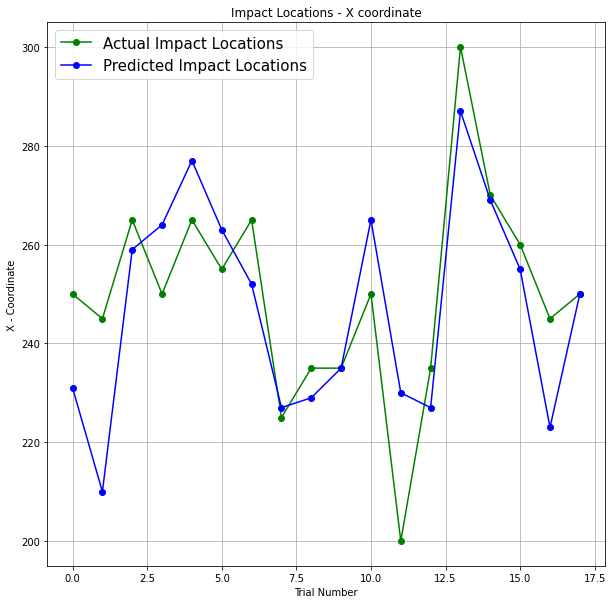

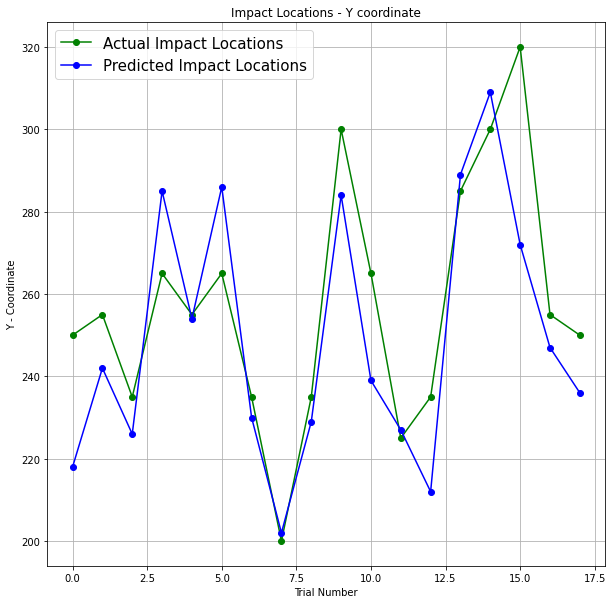

In [59]:
fig = plt.figure(figsize = (10,10))
plt.plot(Oxy_act[:,0],marker = 'o', color = 'green', label = 'Actual Impact Locations')
plt.plot(Oxy_PRED_DN[:,0],marker = 'o', color = 'blue', label = 'Predicted Impact Locations')
plt.title('Impact Locations - X coordinate')
plt.xlabel('Trial Number')
plt.ylabel('X - Coordinate')
plt.legend(prop = {'size' : 15})
plt.grid()
plt.show()

fig = plt.figure(figsize = (10,10))
plt.plot(Oxy_act[:,1],marker = 'o', color = 'green', label = 'Actual Impact Locations')
plt.plot(Oxy_PRED_DN[:,1],marker = 'o', color = 'blue', label = 'Predicted Impact Locations')
plt.title('Impact Locations - Y coordinate')
plt.xlabel('Trial Number')
plt.ylabel('Y - Coordinate')
plt.legend(prop = {'size' : 15})
plt.grid()
plt.show()

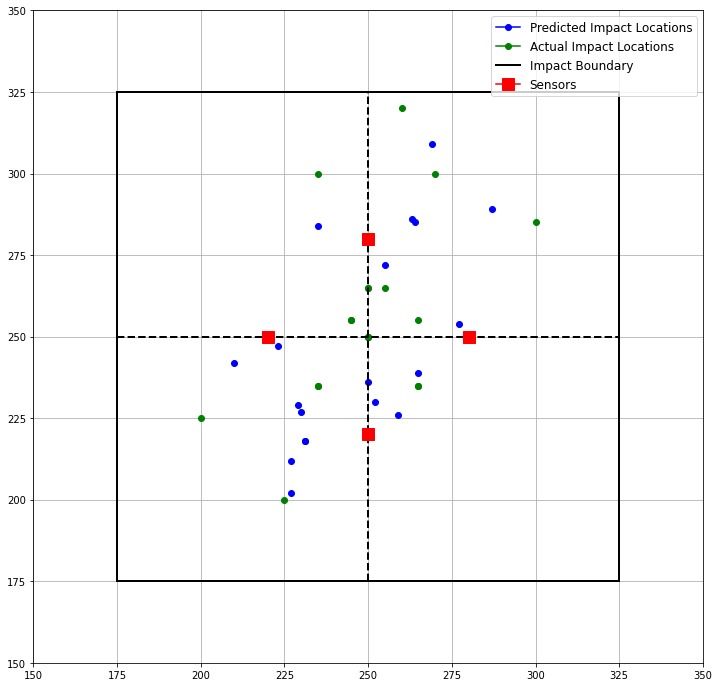

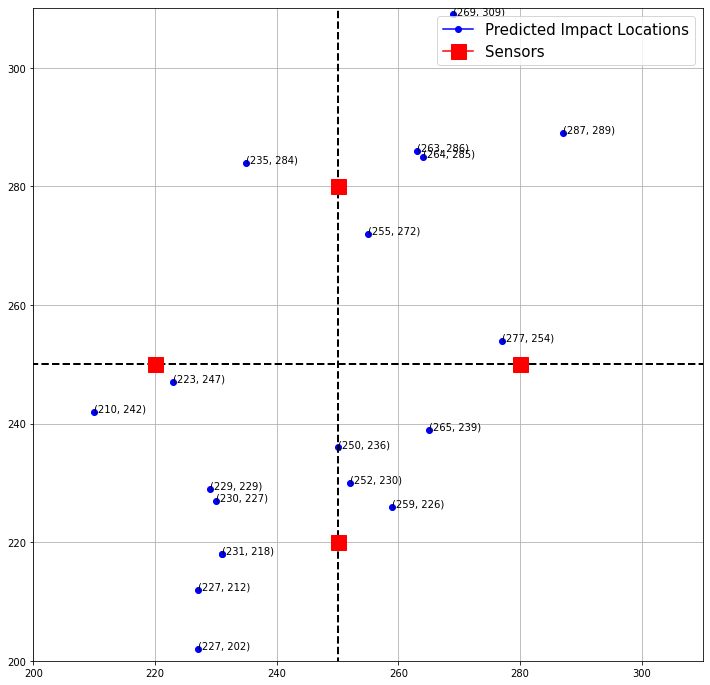

In [60]:
Sy_ax = range(Oxy_PRED.shape[0])
x1 = 175*np.ones(100)
y1 = np.linspace(175,325,100)
x2 = np.linspace(175,325,100)
y2 = 325*np.ones(100)
x3 = 325*np.ones(100)
y3 = y1
x4 = x2
y4 = 175*np.ones(100)
x5 = 250*np.ones(100)
y5 = np.linspace(175,325,100)
x6 = np.linspace(175,325,100)
y6 = 250*np.ones(100)
plt.figure(figsize = (12,12))
for i in range(0,Oxy_PRED_DN.shape[0]):
    plt.plot(Oxy_PRED_DN[i,0],Oxy_PRED_DN[i,1],marker = 'o',color = 'blue')
    plt.plot(Oxy_act[i,0],Oxy_act[i,1],marker = 'o',color = 'green')
    if i == 0:
        plt.plot(Oxy_PRED_DN[i,0],Oxy_PRED_DN[i,1],marker = 'o',color = 'blue',label = 'Predicted Impact Locations')
        plt.plot(Oxy_act[i,0],Oxy_act[i,1],marker = 'o',color = 'green',label = 'Actual Impact Locations')
    #plt.annotate('('+str(Oxy_PRED_DN[i,0])+','+str(Oxy_PRED_DN[i,1])+')',(Oxy_PRED_DN[i,0],Oxy_PRED_DN[i,1]))
plt.plot(x1,y1,color = 'black',lw = 2,label = 'Impact Boundary')
plt.plot(x2,y2,color = 'black',lw = 2)
plt.plot(x3,y3,color = 'black',lw = 2)
plt.plot(x4,y4,color = 'black',lw = 2)
plt.plot(x5,y5,'--',lw = 2,color = 'black')
plt.plot(x6,y6,'--',lw = 2,color = 'black')
plt.plot(250,280,marker = 's',markersize = 12,color = 'red',label = 'Sensors')
#plt.annotate('S1',(250,280))
plt.plot(280,250,marker = 's',markersize = 12,color = 'red')
#plt.annotate('S2',(280,250))
plt.plot(250,220,marker = 's',markersize = 12,color = 'red')
#plt.annotate('S4',(250,220))
plt.plot(220,250,marker = 's',markersize = 12,color = 'red')
#plt.annotate('S3',(220,250))
plt.axis([150,350,150,350])
plt.legend(prop = {'size' : 12})
plt.grid()
plt.show()

plt.figure(figsize = (12,12))
for i in range(0,Oxy_PRED_DN.shape[0]):
    plt.plot(Oxy_PRED_DN[i,0],Oxy_PRED_DN[i,1],marker = 'o',color = 'blue')
    if i == 0:
        plt.plot(Oxy_PRED_DN[i,0],Oxy_PRED_DN[i,1],marker = 'o',color = 'blue',label = 'Predicted Impact Locations')
    plt.annotate('('+str(int(Oxy_PRED_DN[i,0]))+ ', ' +str(int(Oxy_PRED_DN[i,1]))+')',(Oxy_PRED_DN[i,0],Oxy_PRED_DN[i,1]))
# plt.plot(x1,y1,color = 'black',lw = 2)
# plt.plot(x2,y2,color = 'black',lw = 2)
# plt.plot(x3,y3,color = 'black',lw = 2)
# plt.plot(x4,y4,color = 'black',lw = 2)
plt.plot(x5,y5,'--',lw = 2,color = 'black')
plt.plot(x6,y6,'--',lw = 2,color = 'black')
plt.plot(250,280,marker = 's',color = 'red',label = 'Sensors',markersize=15)
plt.plot(280,250,marker = 's',color = 'red',markersize=15)
plt.plot(250,220,marker = 's',color = 'red',markersize=15)
plt.plot(220,250,marker = 's',color = 'red',markersize=15)
plt.axis([200,310,200,310])
plt.legend(prop = {'size' : 15})
plt.grid()
plt.show()

<h1>END OF PROGRAM</h1>